In [1]:
import os
import numpy as np
import pandas as pd
import torch
import random
import time

gpu_id = '0, 1, 2' 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed) # if use multi-GPU

    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

def get_device() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
set_seed(42)

print('GPU number: {}'.format(torch.cuda.device_count()))


GPU number: 0


In [2]:
import random
import torch
import torchaudio
from torchaudio import transforms
from torchvision import transforms as ts

import numpy as np
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold


class AudioUtil():
  # Load an audio file. Return the signal as a tensor and the sample rate
  # deafult setting for sr = 16000
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # stereo = 2, new_channel = 2
  # mono = 1, new_channel = 1
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    elif (new_channel == 2):
      resig = torch.cat([sig, sig])
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig, sig])
    
    return (resig, sr)
  
  # Since Resample applies to a single channel, we resample one channel at a time
  # need to know what is the optimal value for human voice
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # This is for regular procedure.
  # not preferred since no silence included from competition audio files
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms
    if (sig_len > max_len):
      direction = random.randint(0,1)
      # Truncate the signal to the given length, just cut to the direction.
      if direction == 0: # left
        sig = sig[:,:max_len]
      else: # right
        sig = sig[:,sig_len-max_len:]  
    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len
      
      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))
      
      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
  # ----------------------------
  # This applies for our purpose, time shift do not needed for this.
  # ----------------------------
  @staticmethod
  # bit of problematic sigsigsigsig
  def time_sample(aud, max_ms):
    sig, sr = aud
    max_len = sr//1000 * max_ms
    if sig[0].shape[0] > max_len:
      start = np.random.randint(0,sig[0].shape[0]-max_len)
      sam_sig = sig[:,start:start+max_len-1]
      return (sam_sig, sr)
    else:
      con_sig = torch.cat((sig,sig), axis=1)
      while con_sig[0].shape[0] < max_len:
        con_sig = torch.cat((con_sig,sig), axis=1)
      start = np.random.randint(0,con_sig[0].shape[0]-max_len)
      con_sig = con_sig[:, start:start+max_len]
      return (con_sig, sr)   
  ###############################################################################
  # Raw Augmentation
  ###############################################################################
  # ----------------------------
  # noise, flip, others are implemented in torchaudio transformations.   
  # noise_factor < 0.005 is preferred -> heuristic test
  # ----------------------------
  @staticmethod
  def noise(aud, noise_factor):
    sig, sr = aud
    # sampling from gaussian distribution
    noise = np.random.randn((sig.shape[1]))
    num_channels = sig.shape[0]
    noise_data = sig[0] + noise_factor * noise
    if (num_channels > 1):
        noise_data_two =sig[1] + noise_factor*noise
        noise_data_r = torch.stack([noise_data, noise_data_two])
    else:
        noise_data_r = noise_data.reshape(1,-1)  
    
    return (noise_data_r, sr)
  
  @staticmethod
  def flip(aud):
    # if we consider it as speaking out different languages, this might be helpful.
    sig, sr = aud
    flip_sig = np.flip(sig.numpy()).copy()
    
    return torch.from_numpy(flip_sig), sr

  # Spectrogram
  # ----------------------------
  # Generate a Spectrogram , mel_spectrogram + dB
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=128, n_fft=1024, win_len = None, hop_len=512):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, win_length = win_len, hop_length=hop_len, center = True, onesided= True, n_mels=n_mels, mel_scale = 'htk')(sig)
        
    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    
    return (spec)
  # ----------------------------
  # Generate MFCC
  # ----------------------------
  @staticmethod
  def mfcc(aud, n_mels=128, n_mfcc=20,n_fft=2048, hop_len =512):
    sig, sr = aud
    
    spec = transforms.MFCC(sr, n_mfcc, melkwargs={'n_fft': n_fft, 'n_mels': n_mels, 'hop_length': hop_len, 'mel_scale': 'htk'})(sig)
    
    return spec
  
  # Spectrogram Augmentation 
  
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec
    
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
    return aug_spec
  
  #@staticmethod
  # suggest rate btw [0.8, 1.2]
 # def time_stretch(spec, rate=0.8,hop_len =512, n_freq=128):
    
  #  stretch = torchaudio.transforms.TimeStretch(hop_length =hop_len, n_freq = n_freq, fixed_rate = rate)
  #  streched = stretch(spec, 1.2)
  #  return streched
# one_hot_encoding
def to_one_hot(k, classes_num):
    target = np.zeros(classes_num)
    target[k] = 1
    return target

# csv
def data_to_frame(data_dir='./dataset/train', min_files=5, one_hot=False):
    data_path =[]
    data_label = []
    encoded_label = {}
    total_len = len(os.listdir(data_dir))
    
    k=0
    
    for dirname, _, filenames in os.walk(data_dir):
        if str(dirname) == './dataset/train':
            pass
        else:
            label = dirname.split('/')[-1]
            if one_hot:
                encoded_label[label] = to_one_hot(k,total_len)
            else:
                encoded_label[label] = k
            k+=1
        
            if len(filenames) < min_files:
                a = len(filenames)
                while a != min_files:
                    random_file = filenames[np.random.randint(a)]
                    filenames.append(random_file)
                    a+=1
            for filename in filenames:
                data_label.append(label)
                data_path.append(os.path.join(dirname,filename))

# encoded label 어떻게 처릴할지 생각해야함.
# validation 처리
# label은 마지막에 처리
    df = pd.DataFrame({'path' : data_path, 'class' : data_label })
    return df, encoded_label
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class voiceDS(Dataset):
  def __init__(self, df_x, df_y = None, encoded_label = None, channel= 3, transform = None, train=False, test_path=False):
    
    self.df_x = df_x
    self.df_y = df_y
    self.train = train
    self.test_path = test_path
    self.encoded_label = encoded_label
    # transform
    self.transform = transform
    # hyperparameters
    self.duration = 4000
    self.sr = 44100
    self.channel = channel
        
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df_x)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
   
    # Get the Class ID
    if self.test_path:
      audio_file = self.df_x.loc[idx]
      audio_file = self.test_path + '/' + audio_file
  
  
    
    else:
      audio_file = self.df_x.loc[idx, 'path']
      class_id = self.df_y.loc[idx, 'class']
      class_id = self.encoded_label[class_id]
      label = torch.LongTensor(torch.Tensor([class_id]).to(torch.int64)).squeeze()
    

   # class_id =  [list(class_id).index(1)]
   # class_id =  torch.FloatTensor(class_id).squeeze().long()

    # open the file
    aud = AudioUtil.open(audio_file)
    # preprocessing: resample, rechannel, fix time
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel) 
    dur_aud = AudioUtil.time_sample(rechan, self.duration)
    # Convert mel spectrogram -> (num_channels, Mel freq_bands, time_steps) -> later needs to match power of 2.
    sgram = AudioUtil.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
    if self.train:
        pass
    else:
        pass
    # raw augmentation -> later
    # aug = AudioUtil.noise(aud,0.001)
    # Mel augmentation
        #sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    if self.transform:
        sgram = self.transform(sgram)
    if self.test_path:
      return sgram
    else:
      return sgram, label



In [3]:
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn
import timm
import pickle
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn


def training(model, train_dl, val_dl, num_epochs, model_name, encoded_label):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  T_max = len(train_dl)*num_epochs # maximum number of iterations
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0)
  
  best_acc = 0
  best_epoch = 0
  for epoch in range(num_epochs):
    model.train()
    acc = 0
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    avg_loss = 0

    val_acc = 0
    running_val_loss = 0.0
    correct_val_prediction = 0
    total_val_prediction = 0
    avg_val_loss = 0
    
    # Repeat for each batch in the training set
    for i, data in enumerate(tqdm(train_dl)):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        # Normalize the inputs
      #  inputs_m, inputs_s = inputs.mean(), inputs.std()
      #  inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    
    model.eval()
    with torch.no_grad():
        for data in tqdm(val_dl):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, prediction = torch.max(outputs, 1)

            correct_val_prediction += (prediction == labels).sum().item()
            total_val_prediction += prediction.shape[0]
    num_val_batches = len(val_dl)
    avg_val_loss = running_val_loss / num_val_batches
    val_acc = correct_val_prediction/total_val_prediction
    print(f'Epoch: {epoch}, val_Loss: {avg_val_loss:.2f}, val_Accuracy: {val_acc:.2f}')
    if val_acc > best_acc:
      best_acc = val_acc
      best_epoch = epoch
      if not os.path.exists('./checkpoints/{}'.format(model_name)):
        os.mkdir('./checkpoints/{}'.format(model_name))
      torch.save(model,'./checkpoints/{}/best_epoch_{}.pth'.format(model_name,epoch))
      print(f'Epoch: {epoch}, best_Accuracy: {best_acc:.2f} saved!')

  with open('./checkpoints/{}/labels.pickle'.format(model_name),'wb') as fw:
    pickle.dump(encoded_label, fw)
    print('Labels saved!')
  print('Finished Training')
  return best_acc, best_epoch
# inference/ unknown 처리 

def soft_thresh(total_outputs,threshold= 2926):
    
    sf = nn.Softmax(dim=1)
    logits =sf(total_outputs)
    values, prediction = torch.max(logits, 1)
    sorted_values = torch.sort(values)[0]

    threshold_logit = torch.sort(values)[0][threshold]
    unknown = values < threshold_logit
    unknown_indices = unknown.nonzero().squeeze()
    #  alter prediction "unknown" to 4000
    prediction[unknown_indices] = torch.Tensor([4000]*len(unknown_indices)).type(torch.int64).to(device)
        
    return prediction

def inference(model_name, check_point_dir, save_path):
    with open('./checkpoints/{}/labels.pickle'.format(model_name),'rb') as fr:
        encoded_label = pickle.load(fr)
        encoded_label['unknown'] = 4000
    key_values = encoded_label.items()
    new_encoded_label = {str(value): str(key) for key, value in key_values}
    # load model

    model = torch.load(check_point_dir, map_location=device)
    model.eval()
    
    total_outputs = torch.empty(1,3182).to(device)
    with torch.no_grad():
        for data in tqdm(test_dl):
            inputs = data.to(device)
            outputs = model(inputs)      
            total_outputs = torch.cat((total_outputs, outputs))
    
        #    _, prediction = torch.max(outputs, 1)
        #    prediction.detach().cpu().numpy().squeeze().tolist()
        #    predictions+=prediction
    total_outputs = total_outputs[1:,:]
    prediction = soft_thresh(total_outputs)  
    predictions = prediction.detach().cpu().numpy().squeeze().tolist()
    voice_id = []

    for i in predictions:
        voice_id.append(new_encoded_label[str(i)])
    # to csv
    voice_results = pd.DataFrame({'voice_id': voice_id})
    sample_submission['voice_id'] = voice_results
    sample_submission.to_csv(save_path+'/result.csv',header=True, index=False)



In [13]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [11]:
voice_sample = 'ma9T1o3XBa_0.wav'

samples, sample_rate = AudioUtil.open(voice_sample)


In [12]:

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [13]:
a = mel_spectrogram(voice_sample)

AttributeError: 'str' object has no attribute 'size'

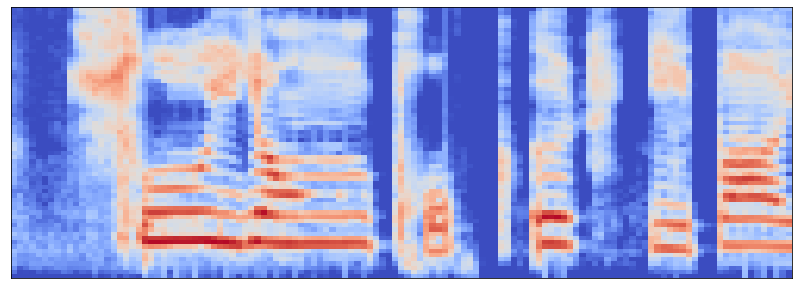

In [57]:
plt.figure(figsize=(14, 5))




# Data Load

In [6]:
# csv_processing, stratified k folds


train_data = data_to_frame(min_files=10, one_hot=False)

#sample_submission = pd.read_csv('./sample_submission.csv')
#test_audio = sample_submission['recording']

df = train_data[0]
encoded_label = train_data[1]
#print(df.tail())
#print(test_audio.head())

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1004)
audio_path = df.drop('class',axis=1)
label = df.drop('path',axis=1)
k_folded_data = list(skf.split(audio_path, label)) # (train_index, test_index)


# first fold k = 1, for training use loop
train_index = k_folded_data[0][0]
test_index = k_folded_data[0][1]
# train, val dataframe
train_x, val_x = audio_path.iloc[train_index].reset_index(), audio_path.iloc[test_index].reset_index()
train_y, val_y = label.iloc[train_index].reset_index(), label.iloc[test_index].reset_index()

### transform later change to albu or additional 

num_channels = 1

if num_channels ==3:
  mean = (0.485, 0.456, 0.406) # RGB
  std = (0.229, 0.224, 0.225) # RGB
elif num_channels ==1:
  mean = 0.485
  std = 0.229
  
torchvision_transform = ts.Compose([
  ts.Normalize(mean,std)])
# training    

train_dataset = voiceDS(train_x, train_y, encoded_label, num_channels, transform = torchvision_transform, train=True)
val_dataset = voiceDS(val_x, val_y, encoded_label, num_channels, transform = torchvision_transform)

# testing
#test_dataset= voiceDS(test_audio, num_channels, transform= torchvision_transform, test_path='./dataset/test')

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8)

#test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, drop_last = False)


Training/ Inference

In [6]:
# try out 1 channel and compare the result with 3 channel


model_name ='resnet101'
model=timm.create_model(model_name, pretrained=True, num_classes=3182, in_chans = num_channels)

#model = torch.nn.DataParallel(model, device_ids=list(range(3)))
model.to(device)

start = time.time()
best_acc, best_epoch = training(model, train_dl, val_dl, 18, model_name, encoded_label)
end = time.time()
print(end-start)

print('training_completed: acc:{} epoch:{}'.format(best_acc, best_epoch))

save_path = '/home/jinyong/competition/checkpoints/{}/'.format(model_name)
check_point_dir = '/home/jinyong/competition/checkpoints/{}/best_epoch_{}.pth'.format(model_name, best_epoch)

inference(model_name, check_point_dir, save_path)

100%|██████████| 3755/3755 [10:03<00:00,  6.22it/s]


Epoch: 0, Loss: 6.55, Accuracy: 0.03


100%|██████████| 939/939 [01:37<00:00,  9.62it/s]


Epoch: 0, val_Loss: 4.57, val_Accuracy: 0.14
Epoch: 0, best_Accuracy: 0.14 saved!


100%|██████████| 3755/3755 [09:42<00:00,  6.45it/s]


Epoch: 1, Loss: 3.44, Accuracy: 0.28


100%|██████████| 939/939 [01:16<00:00, 12.31it/s]


Epoch: 1, val_Loss: 2.64, val_Accuracy: 0.42
Epoch: 1, best_Accuracy: 0.42 saved!


100%|██████████| 3755/3755 [09:46<00:00,  6.40it/s]


Epoch: 2, Loss: 1.93, Accuracy: 0.54


100%|██████████| 939/939 [01:22<00:00, 11.35it/s]


Epoch: 2, val_Loss: 2.35, val_Accuracy: 0.48
Epoch: 2, best_Accuracy: 0.48 saved!


100%|██████████| 3755/3755 [09:48<00:00,  6.38it/s]


Epoch: 3, Loss: 1.18, Accuracy: 0.70


100%|██████████| 939/939 [01:17<00:00, 12.11it/s]


Epoch: 3, val_Loss: 1.60, val_Accuracy: 0.63
Epoch: 3, best_Accuracy: 0.63 saved!


100%|██████████| 3755/3755 [09:41<00:00,  6.45it/s]


Epoch: 4, Loss: 0.67, Accuracy: 0.82


100%|██████████| 939/939 [01:16<00:00, 12.31it/s]


Epoch: 4, val_Loss: 1.69, val_Accuracy: 0.63
Epoch: 4, best_Accuracy: 0.63 saved!


100%|██████████| 3755/3755 [09:48<00:00,  6.38it/s]


Epoch: 5, Loss: 0.42, Accuracy: 0.88


100%|██████████| 939/939 [01:19<00:00, 11.87it/s]


Epoch: 5, val_Loss: 1.49, val_Accuracy: 0.67
Epoch: 5, best_Accuracy: 0.67 saved!


100%|█████████▉| 3744/3755 [10:55<00:01,  6.23it/s]

In [12]:
timm.list_models(pretrained=True)

592

Inference